## Import all the packages

In [285]:

# Pandas for data processing
import pandas as pd
import numpy as np
# Meteostat model
from meteostat import Stations, Daily


# Statsmodels for initial regression models
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col


# Packages for machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression



# Yahoo Finance for data
import yfinance as yf


# Date and timer 
from datetime import datetime
import time


# Packages to plot
import matplotlib.pyplot as plt
import seaborn as sns

# Data initialization

### I have installed meteostat which a free python library containing free data, given stationpoints around the world

- First I need a way to find the name of the city and get the Latitude and longitude data for that city

- There is some data that I am missing. The prices are moving together but I feel there are some other regions I am missing. Looking online I saw that Columbia which is Geographically close to Brazil is also a major coffee producers

- I downloaded the data for Colombia from the same website

- I downloaded the data from: https://simplemaps.com/data/br-cities

I have the csv files as is and imported it into the code 

In [286]:
br_cities = pd.read_csv('./br.csv')
co_cities = pd.read_csv('./co.csv')
#Now I have cities where I have regions in Brazil and Colombia
cities = pd.concat([br_cities,co_cities])

In [287]:
cities.tail()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
79,Leticia,-4.2167,-69.9333,Colombia,CO,Amazonas,admin,33503.0,32450.0
80,La Virginia,4.9167,-75.8333,Colombia,CO,Risaralda,minor,32330.0,32330.0
81,Mitú,1.1983,-70.1733,Colombia,CO,Vaupés,admin,28382.0,28382.0
82,Inírida,3.8653,-67.9239,Colombia,CO,Guainía,admin,20279.0,19816.0
83,Puerto Carreño,6.1903,-67.4836,Colombia,CO,Vichada,admin,16763.0,16763.0


## Brazil's coffee production
#### Since Brazil is a big country I want to narrow down where the production actually happens
According to USDA report on Table 2: https://apps.fas.usda.gov/newgainapi/api/Report/DownloadReportByFileName?fileName=Coffee%20Semi-annual_Brasilia_Brazil_BR2023-0031

We have access to states where most of the coffee farming happens. These states are:
- Mina Gerias with 33.1 Million kg bags in 2023
- Sao Paulo with 5.6 Million kg bags in 2023
- Espitito Santo (mostly Rubusta)

**Another big producer of Coffee in the same region is Colombia, I would love to have some data for Columbia as well.**
Regions with coffe production in Columbia also called the Coffee triable


https://ourworld.unu.edu/en/climate-change-impacts-to-drive-up-coffee-prices

https://www.nasdaq.com/articles/arabica-coffee-prices-strengthen-on-dry-conditions-in-brazil

- Antioquia
- Huila
- Tolima 

**With that knowledge I will close down on weather data for the cities in those regions!**



In [288]:
admin = cities['admin_name'].value_counts()
admin.head(5)

admin_name
São Paulo    23
Bahia        19
Maranhão     12
Ceará        11
Antioquia    11
Name: count, dtype: int64

In [289]:
regions = ['Minas Gerais','São Paulo']
#,'Tolima','São Paulo','Hulia','Antioquia'
city = cities[cities['admin_name'].isin(regions)]
city.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,São Paulo,-23.5500,-46.6333,Brazil,BR,São Paulo,admin,23086000.0,12252023.0
2,Belo Horizonte,-19.9167,-43.9333,Brazil,BR,Minas Gerais,admin,5328000.0,2502557.0
7,Santos,-23.9369,-46.3250,Brazil,BR,São Paulo,NaN,1897551.0,418608.0
12,Guarulhos,-23.4628,-46.5328,Brazil,BR,São Paulo,NaN,1324781.0,1324781.0
14,Campinas,-22.9058,-47.0608,Brazil,BR,São Paulo,NaN,1213792.0,1213792.0


### Here I am downloading the average tempratures and precipitation data for the regions in Brazil where we have most of the coffee produciton. 

I have daily weather data starting from **2019** unitl end of **2023** from the closest stations where data is available in these regions/citites. 

In [290]:
start = datetime(2019, 1, 1)
end = datetime(2024, 1, 1)
#empty dataframe
wdata = pd.DataFrame()
ix = 0

for i in city['city']:
    #The servers used are free but we don't want them to be overloaded with data collection and the code to crash. So I have put a timer between entries!
    time.sleep(0.1)
    name = i
    #Getting latitude and longitude values for each cities in our dataset
    lat = city.loc[city['city'] == i, 'lat'].values[0]
    lng = city.loc[city['city'] == i, 'lng'].values[0]

    #Calling the station
    stations = Stations()
    #Plugging in the lat and lon values for the city
    stations = stations.nearby(lat, lng)
    station = stations.fetch(1)  # Fetch closest station

    # Fetch daily historical data for the specified station and time period
    name = Daily(station, start, end)
    name = name.fetch()
    # Select only the columns for temperature and precipitation
    name = name[['tavg','prcp']]
    #Putting time index as a column so we can merge easily
    name.reset_index(inplace=True)
    #Renaming the columns so we have a better idea which column has the data for which city
    name = name.rename(columns={'tavg':f'tavg_{i}'})
    name = name.rename(columns={'prcp':f'prcp_{i}'})
    #wdata is ann empty dataset. The first time I want it to take the values of the first city, and then after merge new cities into it
    if ix == 0:
        wdata = name.copy()
        ix +=1
    else:
        wdata = wdata.merge(name,right_on='time',left_on='time',how='left')

wdata = wdata.drop_duplicates(subset='time')
# So when we divide the data later both have the dates

### Saving a copy of the file, just in case the servers aren't functionning

In [291]:
wdata = wdata.set_index('time')
wdata.to_csv('weather.csv', index=False)

#### I want the data to be divided between precepitaion data and average temprature data and create a new dataframe that will only consider when we have extreme temperatures. Coffee beans cannot properly grow above 24°C 

In [292]:
prcp_columns = [col for col in wdata.columns if col.startswith('prcp')]
# Create a new DataFrame with these columns
prcp_df = wdata[prcp_columns]
prcp_df['Average prcp'] = prcp_df.mean(axis=1, skipna=True)
prcp_df.reset_index(inplace=True)

tavg_columns = [col for col in wdata.columns if col.startswith('tavg')]
# Create a new DataFrame with these columns
tavg_df = wdata[tavg_columns]
tavg_df['Average Temperature'] = tavg_df.mean(axis=1, skipna=True)
tavg_df.reset_index(inplace=True)
ext = tavg_df[tavg_df['Average Temperature']>= 24.5]# extreme weather cases 



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Coffee Prices specifically Arabica, the coffee beans that is produced in Brazil

I want the data for the same time periodes as the weather data available to me

**Note that these are worldwide coffee prices of *Arabica* and not just Brazil's.** As we have seen before Brazil's produces 40% of world's coffee beans so it must have 

In [293]:
arabica = "KC=F"

price = yf.download(arabica,start,end)
price.reset_index(inplace=True)


price['AVG_Price'] = (price['High'] + price['Low']) / 2
price = price[['Date','AVG_Price','Volume']]

brazil = "BRL=X"
exchange = yf.download(brazil,start,end)
exchange.reset_index(inplace=True)

exchange['exchange'] = (exchange['High'] + exchange['Low']) / 2
exchange = exchange[['Date','exchange','Volume']]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## I am now merging everything together here in one dataframe

In [294]:
main = pd.merge(tavg_df,prcp_df,right_on='time',left_on='time',how ='inner')
main = main.merge(price, right_on='Date',left_on='time',how ='inner')
main = main.merge(exchange, right_on='Date',left_on='Date',how ='inner')
main = main.drop_duplicates(subset='time')
main['Adj_Price'] = main['exchange'] * main['AVG_Price']

main['return'] = main['AVG_Price'].pct_change()*100
main['cum_return'] = main['return'].cumsum()

main['lagged_price'] = main['Adj_Price'].shift(50)
main = main.dropna(subset='lagged_price')


main['lag_return'] = main['Adj_Price'].pct_change()
main['cum_lag_return'] = main['lag_return'].cumsum()

# In Machine Learning Part I want to use Monthly and Yearly data to predict prices 
main['year'] = main['time'].dt.year
main['month'] = main['time'].dt.month


# Given that the Harvest season is between April and September I included October just in case. 
# I can use this data later as a classifier
main['Status'] = np.where((main['month'] >= 4) & (main['month'] <= 10), 'Harvest', 'Non-Harvest')

main['Extereme'] = ext['Average Temperature']
main.head(4)

,time,tavg_São Paulo,tavg_Belo Horizonte,tavg_Santos,tavg_Guarulhos,tavg_Campinas,tavg_Santo André,tavg_Osasco,tavg_Contagem,tavg_Mauá,...,Adj_Price,return,cum_return,lagged_price,lag_return,cum_lag_return,year,month,Status,Extereme
50,2019-03-15,23.4,24.0,25.2,NaN,23.3,22.7,23.4,NaN,22.7,...,363.197766,-0.079223,-6.256994,388.860104,NaN,NaN,2019,3,Non-Harvest,24.695833
51,2019-03-18,24.8,23.9,26.5,24.9,24.6,24.6,24.8,NaN,24.6,...,357.204518,-1.004225,-7.261219,382.211108,-0.016501,-0.016501,2019,3,Non-Harvest,NaN
52,2019-03-19,24.7,24.0,27.0,24.8,25.6,24.9,24.7,NaN,24.9,...,353.119503,-0.213566,-7.474785,381.125839,-0.011436,-0.027937,2019,3,Non-Harvest,NaN
53,2019-03-20,22.6,23.6,24.6,21.9,24.1,21.8,22.6,NaN,21.8,...,361.942522,2.273947,-5.200838,379.200514,0.024986,-0.002951,2019,3,Non-Harvest,25.748000


Here I have daily weather data for each state row wise

# Data visualization

In [295]:
#This changes the DataFrame from a wide format to a long format where each 
#row represents a single observation, making it easier to plot using functions that expect data in this format.
df_melted = tavg_df.reset_index().melt(id_vars='time', var_name='City', value_name='Temperatures')

df = df_melted.merge(main, right_on='Date',left_on='time',how='inner')
df_melted.head()

,time,City,Temperatures
0,2019-01-01,index,0.0
1,2019-01-02,index,1.0
2,2019-01-03,index,2.0
3,2019-01-04,index,3.0
4,2019-01-05,index,4.0


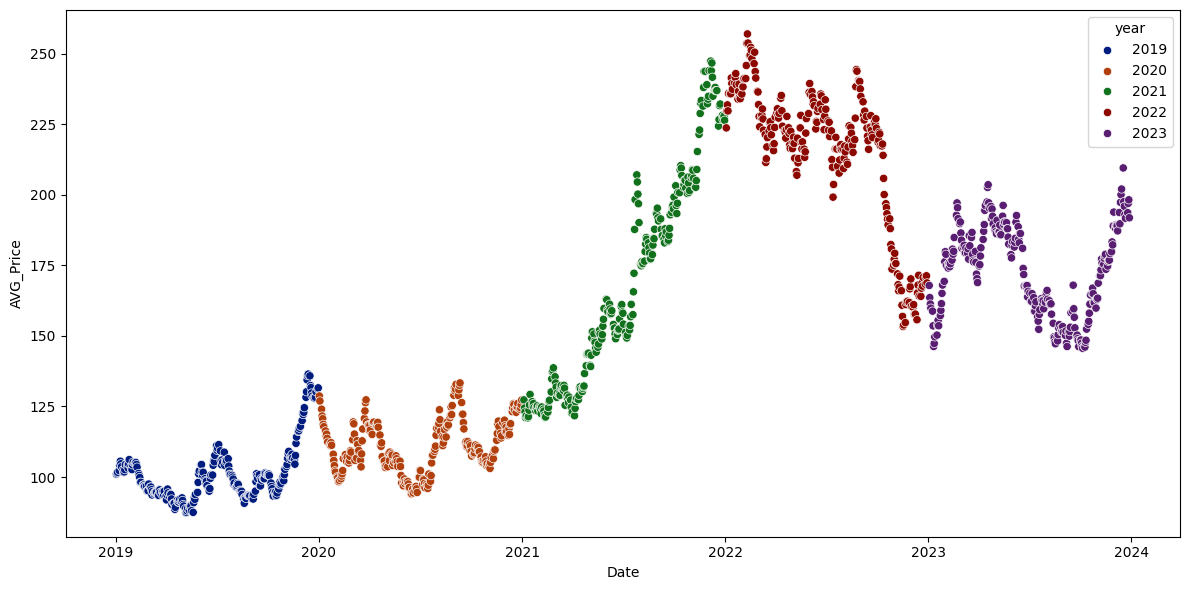

In [296]:
# This condition selects rows where the month is not March or April
filtered_df = main[(main['time'].dt.month != 6) & (main['time'].dt.month != 7)& (main['time'].dt.month != 8)]

price['year'] = price['Date'].dt.year  # Extracting year from date

fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=price, x='Date', y='AVG_Price',hue='year', ax=axs,palette='dark')

# Adjust layout
plt.tight_layout()
plt.show()

## Temprature Data

The plot bellow shows the average temrature changes accross cities and time. We can clearly see that the tempratures across this region is quite similar. We don't have major outliers where the temprature of one city is much higher or lower then the average. 
We have a total average of around **22.3°C**

Further more we can see that the temprature has a **V** shape, where in summer the tempratures are high and in winter they are quite low. In general however, the tempratures are quite stable in this region. 

If we want to look at the average temprature for all the citis across time in figure 2 we see much clearly the **V** shape we are talking about.

The average tempratures across cities are much more stable, where we see a low of around **16°C** and a high of **24°C**

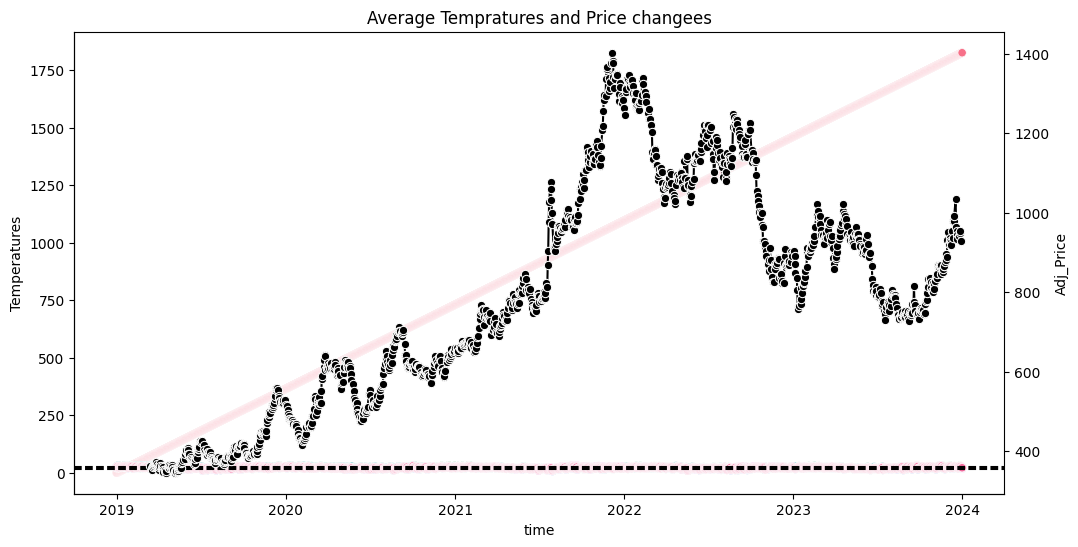

<Figure size 1500x600 with 0 Axes>

In [297]:
fig, axs = plt.subplots(figsize=(12, 6))

# Computing the temprature mean across cities and time.
average_temp = tavg_df['Average Temperature'].mean()

# Create a plot using Seaborn
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df_melted, x='time', y='Temperatures', hue='City',legend=False,ax=axs)

ax2 = axs.twinx()
sns.lineplot(data=main, x='Date', y='Adj_Price',color='black',marker='o',ax = ax2)


axs.set_title('Average Tempratures and Price changees')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

axs.axhline(y=24,color='black',linestyle='--')
axs.axhline(y=16,color='black',linestyle='--')

# Show the plot
plt.show()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


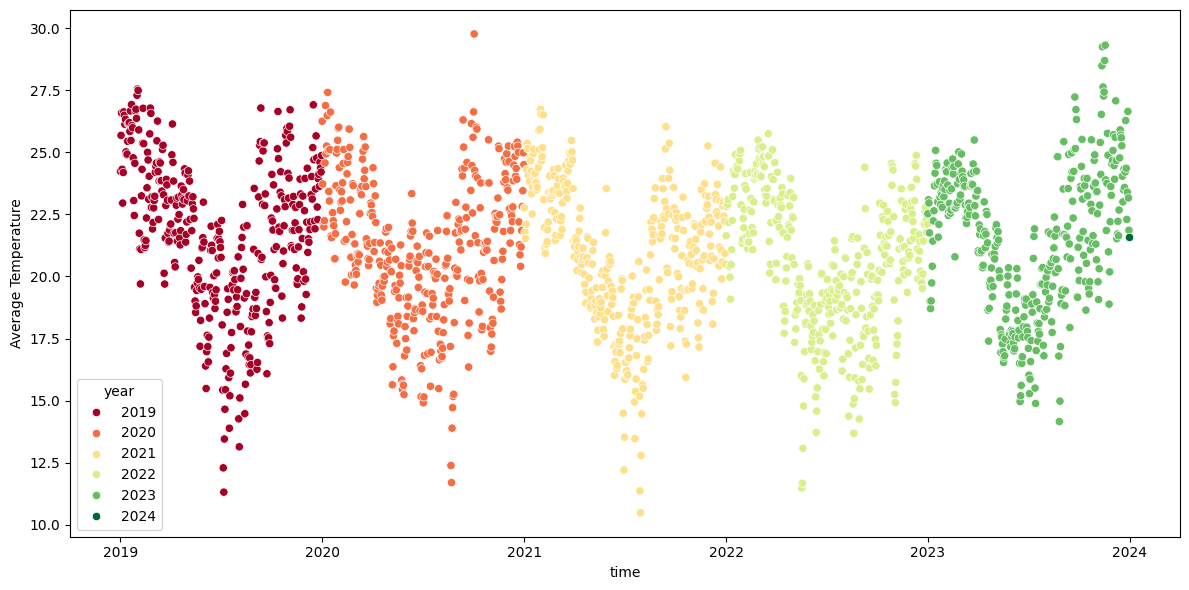

In [298]:
tavg_df.reset_index(inplace=True)
tavg_df['year'] = tavg_df['time'].dt.year  # Extracting year from date
fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=tavg_df, x='time', y='Average Temperature',hue='year', ax=axs,palette='RdYlGn')

# Adjust layout
plt.tight_layout()
plt.show()


## Precipitation Data

Here we see that for before 2021, we have very little data, most of it is set at zero or the data doesn't even exists. Further more we have huge outliers, where we have precipitation of 40 to 50 mm, for years before 2021 which does seem a bit odd. 

I believe this is because of data issue, and that the server might have errors for precipitation data before 2021.

I will there for cut to years after 2021, to see how the data looks

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


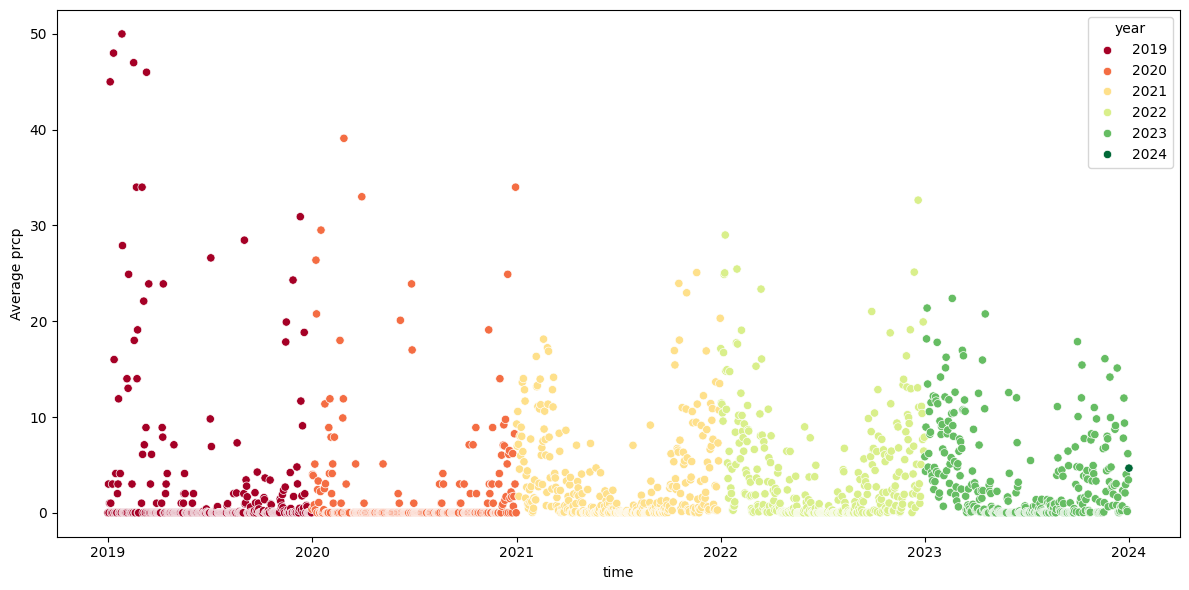

In [299]:
prcp_df['year'] = prcp_df['time'].dt.year  # Extracting year from date
fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=prcp_df, x='time', y='Average prcp',hue='year', ax=axs,palette='RdYlGn')

# Adjust layout
plt.tight_layout()
plt.show()


Now that we look at the precipitation data for year **2021** onwards, we can see a **U** shapes. There is very little precipitation in the summer but in winter seasen there are a lot of rainfall, especially in year 2022, with high precipitation

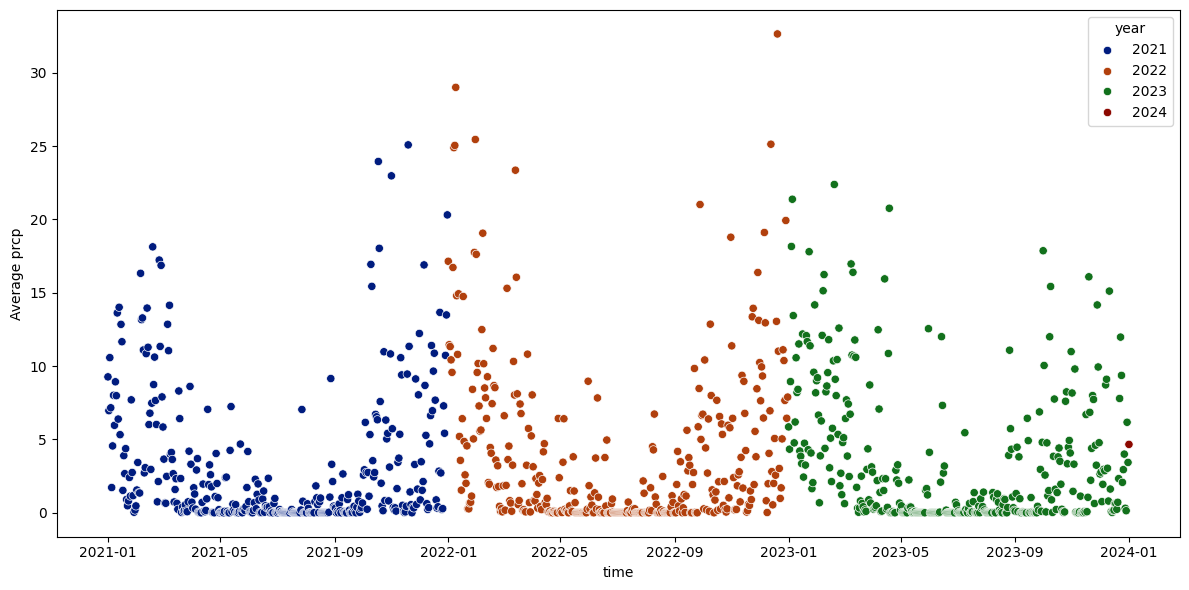

In [300]:
newprcp_df = prcp_df[prcp_df['year']>=2021]

fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=newprcp_df, x='time', y='Average prcp',hue='year', ax=axs,palette='dark')

# Adjust layout
plt.tight_layout()
plt.show()

## Comparing Weather to returns

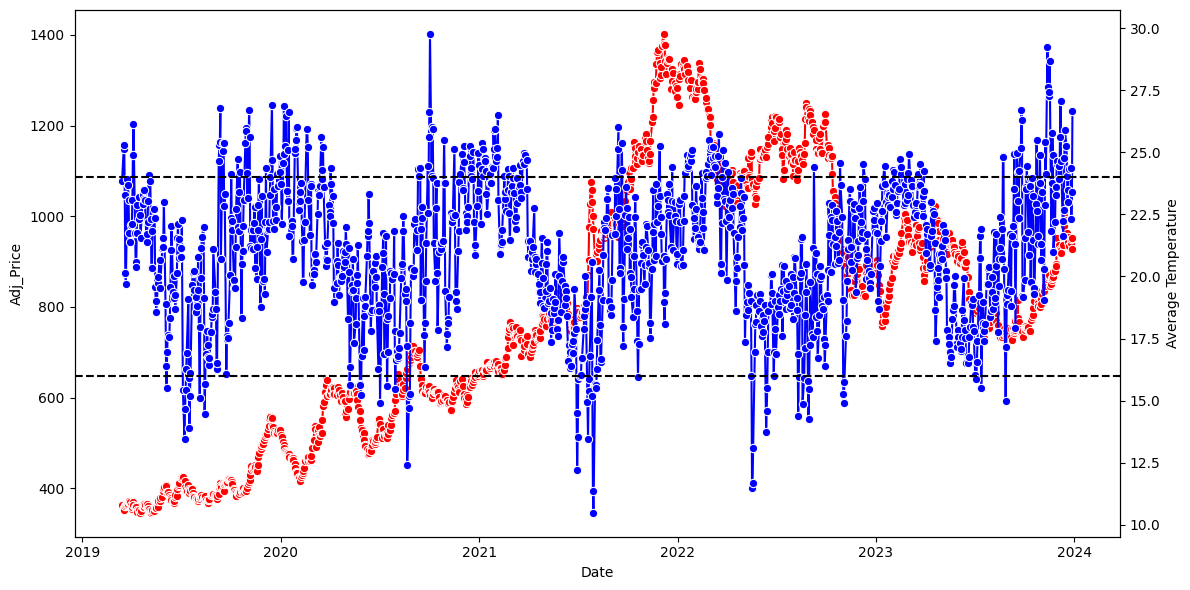

In [301]:
#main.set_index('Date', inplace=True)
fig, axs = plt.subplots(figsize=(12, 6))


sns.lineplot(data=main, x='Date', y='Adj_Price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=main, x='time', y='Average Temperature', ax=axs2, color='blue',marker='o')

#axs.axvspan(pd.Timestamp('2022-10-01'), pd.Timestamp('2023-05-03'), color='red', alpha=0.2)

axs2.axhline(y=24,color='black',linestyle='--')
axs2.axhline(y=16,color='black',linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()

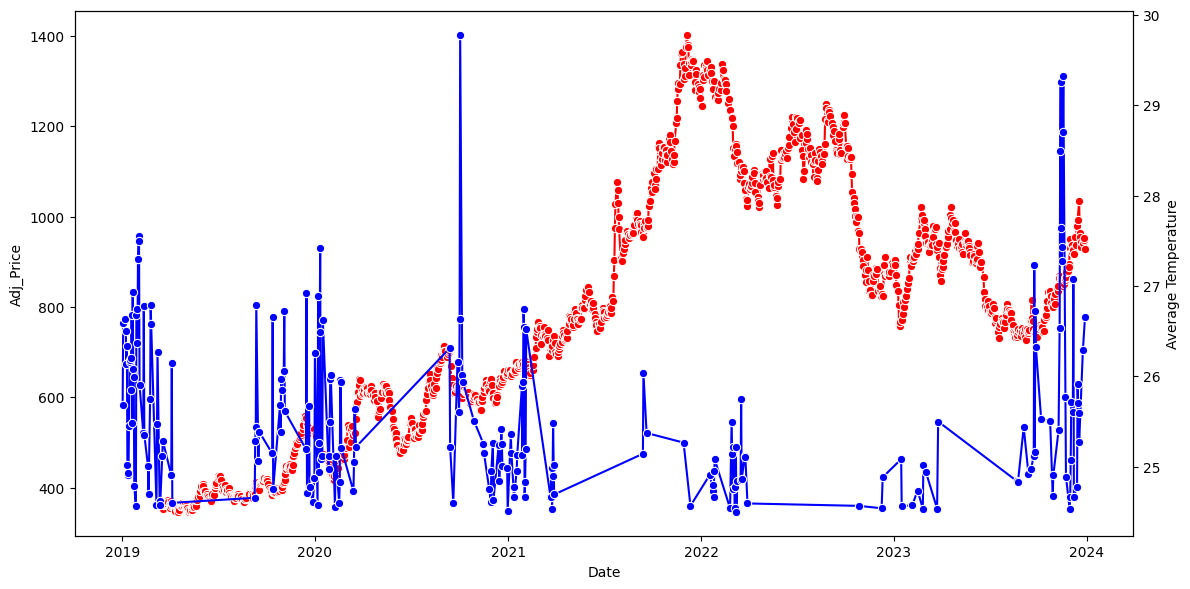

In [302]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.lineplot(data=main, x='Date', y='Adj_Price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=ext, x='time', y='Average Temperature', ax=axs2, color='blue',marker='o')

#axs.axvspan(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-05-03'), color='red', alpha=0.2)
# Adjust layout
plt.tight_layout()
# Once I have seen that the Extereme Temperature are not 
main = main.drop(columns=['Volume_y','Extereme'])
main = main.rename(columns={'Volume_x':'Volume'})
plt.show()


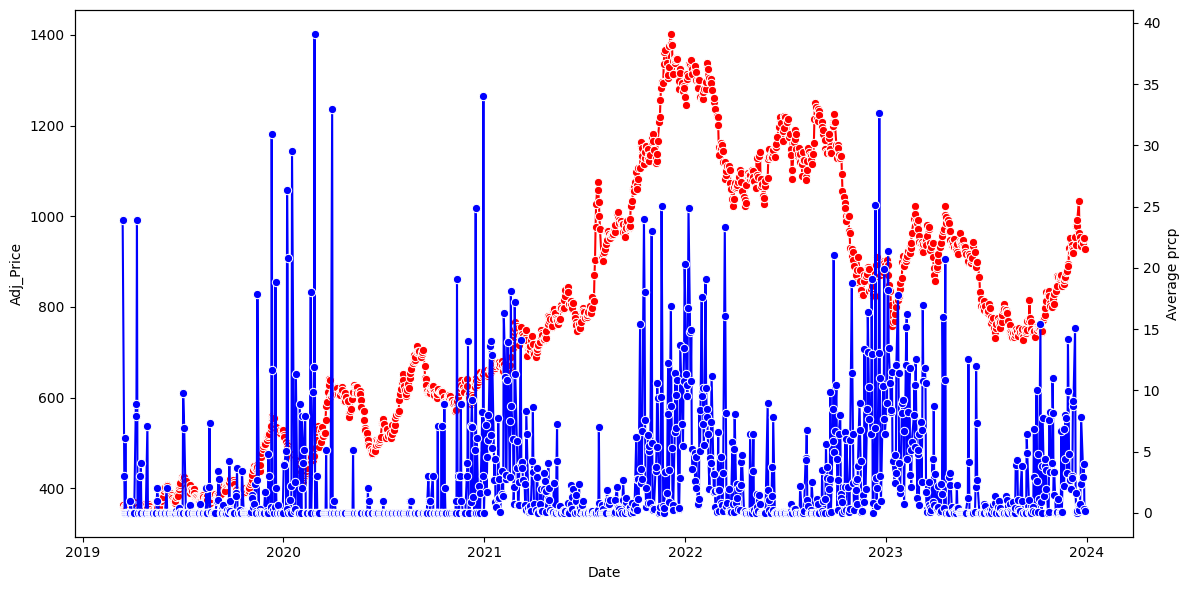

In [303]:
fig, axs = plt.subplots(figsize=(12, 6))


sns.lineplot(data=main, x='Date', y='Adj_Price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=main, x='time', y='Average prcp', ax=axs2, color='blue',marker='o')

# Adjust layout
plt.tight_layout()
plt.show()

# Running some Linear regressions to look for some correlations

## Regression plots

Text(0, 0.5, 'Cummulative Lagged returns (50Days) returns on Coffee beans')

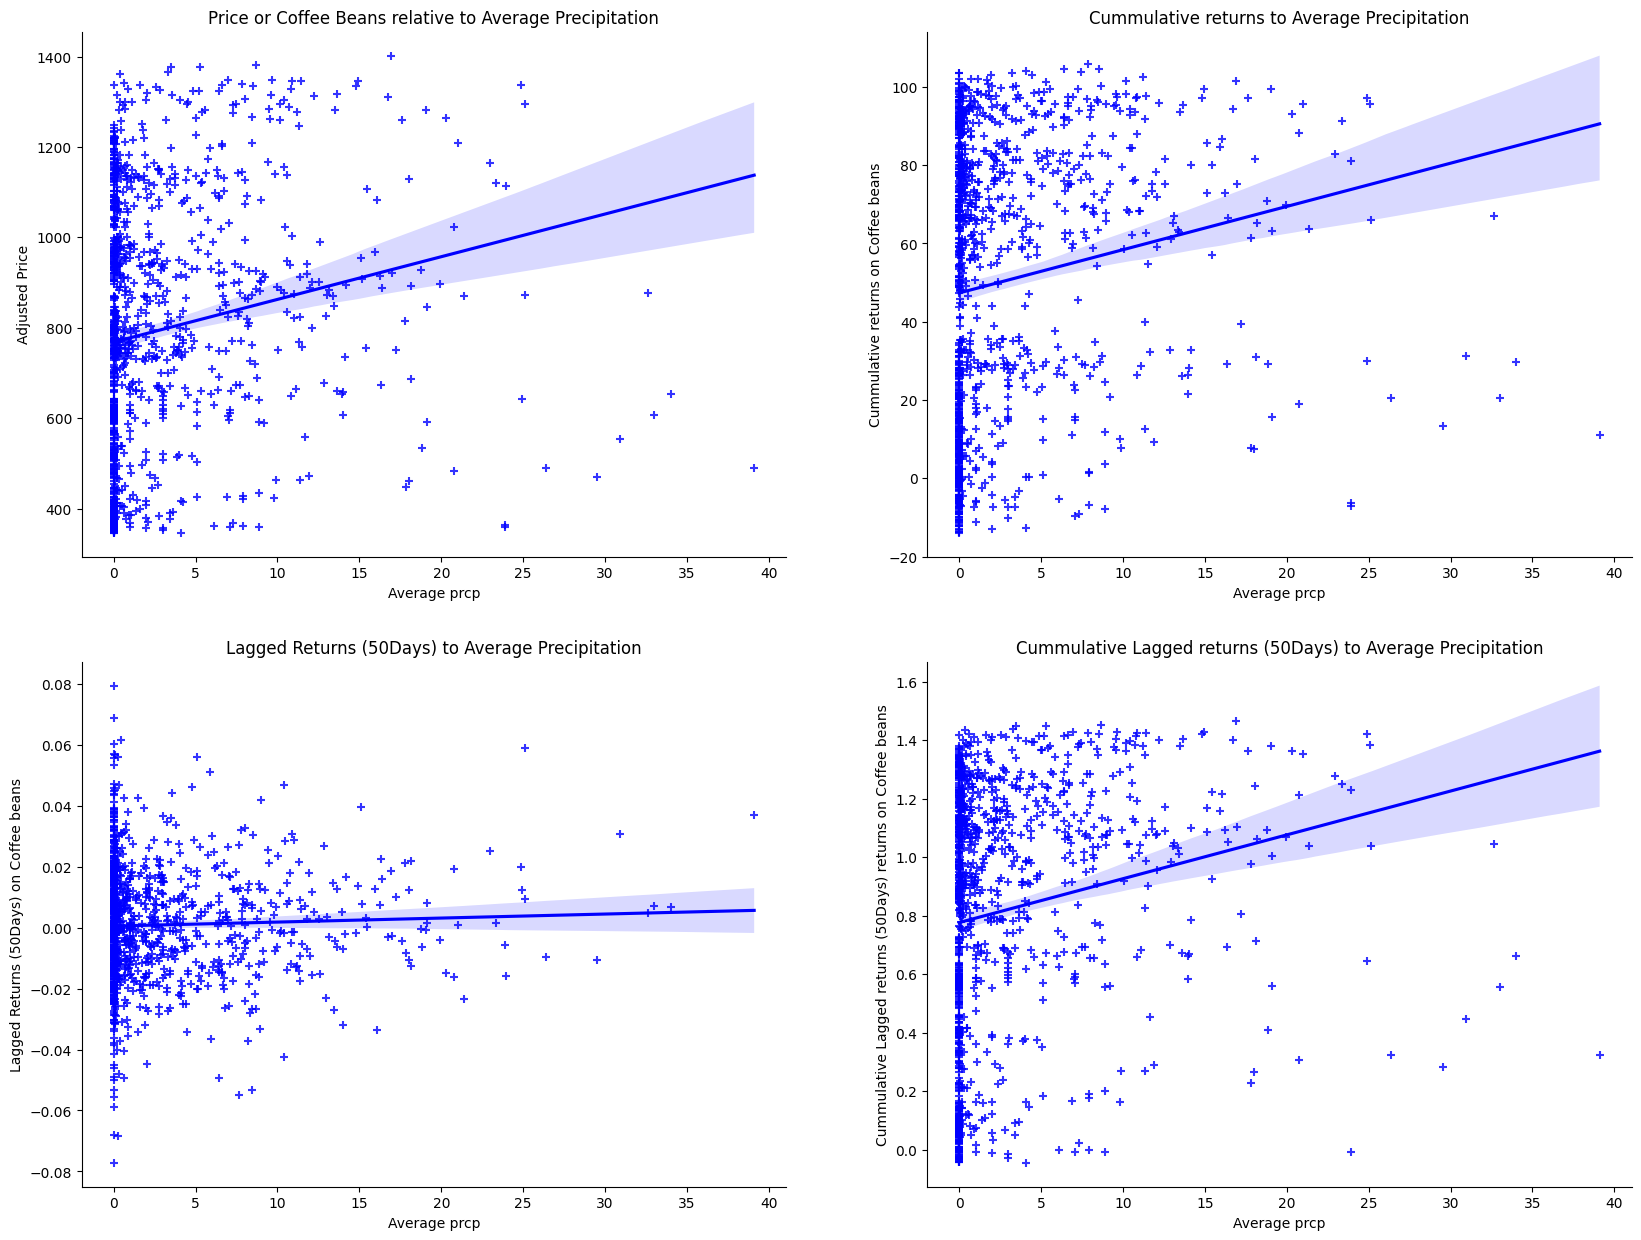

In [304]:
fig, ax = plt.subplots(figsize=(20,15) ,ncols=2, nrows=2)

sns.regplot(x='Average prcp', y='Adj_Price', data=main, color='blue', marker='+',ax= ax[0][0])
sns.regplot(x='Average prcp', y='cum_return', data=main, color='blue', marker='+',ax = ax[0][1])
sns.regplot(x='Average prcp', y='lag_return', data=main, color='blue', marker='+',ax = ax[1][0])
sns.regplot(x='Average prcp', y='cum_lag_return', data=main, color='blue', marker='+',ax = ax[1][1])




ax[0][0].set_title('Price or Coffee Beans relative to Average Precipitation')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].set_ylabel("Adjusted Price")


ax[0][1].set_title('Cummulative returns to Average Precipitation')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].set_ylabel("Cummulative returns on Coffee beans")

ax[1][0].set_title('Lagged Returns (50Days) to Average Precipitation')
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].set_ylabel("Lagged Returns (50Days) on Coffee beans")

ax[1][1].set_title('Cummulative Lagged returns (50Days) to Average Precipitation')
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].set_ylabel("Cummulative Lagged returns (50Days) returns on Coffee beans")


Text(0, 0.5, 'Cummulative Lagged returns (50Days) returns on Coffee beans')

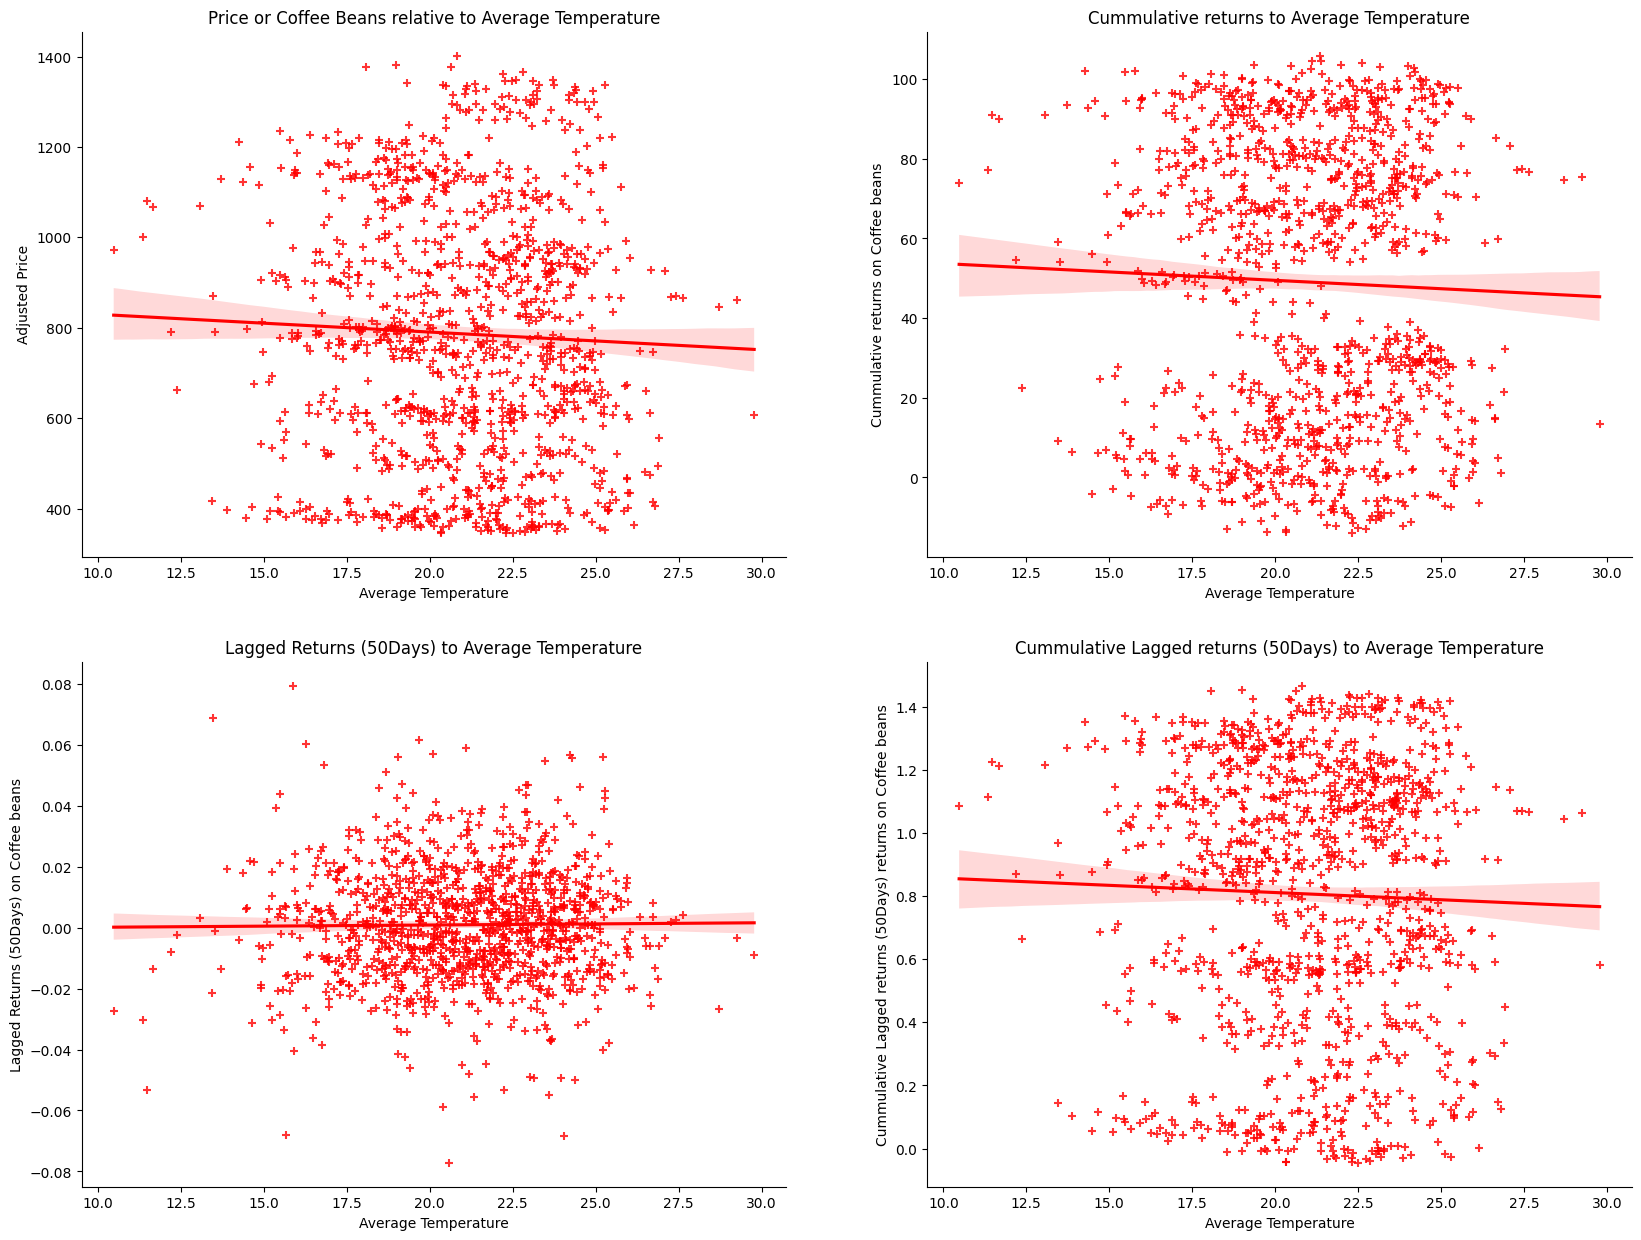

In [305]:
fig, ax = plt.subplots(figsize=(20,15) ,ncols=2, nrows=2)

sns.regplot(x='Average Temperature', y='Adj_Price', data=main, color='red', marker='+',ax= ax[0][0])
sns.regplot(x='Average Temperature', y='cum_return', data=main, color='red', marker='+',ax = ax[0][1])
sns.regplot(x='Average Temperature', y='lag_return', data=main, color='red', marker='+',ax = ax[1][0])
sns.regplot(x='Average Temperature', y='cum_lag_return', data=main, color='red', marker='+',ax = ax[1][1])


ax[0][0].set_title('Price or Coffee Beans relative to Average Temperature')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].set_ylabel("Adjusted Price")


ax[0][1].set_title('Cummulative returns to Average Temperature')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].set_ylabel("Cummulative returns on Coffee beans")

ax[1][0].set_title('Lagged Returns (50Days) to Average Temperature')
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].set_ylabel("Lagged Returns (50Days) on Coffee beans")

ax[1][1].set_title('Cummulative Lagged returns (50Days) to Average Temperature')
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].set_ylabel("Cummulative Lagged returns (50Days) returns on Coffee beans")


## Regression tables

We see that the constant is statistically significant on both HC3 and HuberT model which are less sensitive to outliers.
- The temprature coefficient however is not statistically signicant, in both HC3 and HuberT model. This implies there is no linear correlation between average tempretures in this region and prices. However, average precipitation does have a statistically significant impact

In [306]:
Y = main['cum_lag_return']  # Dependent variable
X = sm.add_constant(main['Average Temperature'])  # Independent variable


# Create the OLS model
model1 = sm.OLS(Y, X,missing='drop')
model2 = RLM(Y, X, M=sm.robust.norms.HuberT(),missing='drop')
# Fit the model
HC3T = model1.fit(cov_type='HC3')

HUBERT = model2.fit()

#########################################
#########################################

X = sm.add_constant(main['Average prcp'])  # Independent variable

# Create the OLS model
model1 = sm.OLS(Y, X,missing='drop')
model2 = RLM(Y, X, M=sm.robust.norms.HuberT(),missing='drop')
# Fit the model
HC3P = model1.fit(cov_type='HC3')
HUBERP = model2.fit()

info_dict={'R-squared': lambda x:f"{x.rsquared:.2f}",
          'NO. observations': lambda x: f"{int(x.nobs):d}"}



In [307]:
results_table_county = summary_col(results = [HC3T, HUBERT, HC3P, HUBERP],
                                  stars = True,
                                  model_names=['[HC3]',
                                              '[HUBER]',
                                              '[HC3]',
                                              '[HUBER]'],
                                  info_dict = info_dict,
                                  )
print(results_table_county)


                     [HC3] I  [HUBER] I  [HC3] II [HUBER] II
------------------------------------------------------------
const               0.9021*** 0.9296*** 0.7766*** 0.7843*** 
                    (0.0899)  (0.0994)  (0.0150)  (0.0155)  
Average Temperature -0.0046   -0.0054                       
                    (0.0042)  (0.0047)                      
Average prcp                            0.0150*** 0.0165*** 
                                        (0.0030)  (0.0027)  
R-squared           0.0009              0.0315              
R-squared Adj.      0.0001              0.0306              
NO. observations    1207      1207      1162      1162      
R-squared           0.00                0.03                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Machine learning

In [308]:
main = main.dropna(subset=['lag_return','cum_lag_return','Average prcp','Average Temperature'])

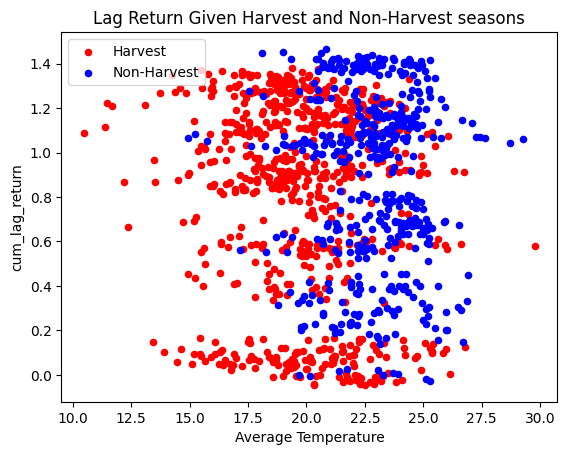

In [309]:
# Plotting
fig, ax = plt.subplots()
colors = {'Harvest':'red', 'Non-Harvest':'blue'}

grouped = main.groupby('Status')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Average Temperature', y='cum_lag_return', label=key, color=colors[key])

plt.title('Lag Return Given Harvest and Non-Harvest seasons')
plt.xlabel('Average Temperature')
plt.ylabel('cum_lag_return')
plt.show()

In [310]:
main.head(2)

,time,tavg_São Paulo,tavg_Belo Horizonte,tavg_Santos,tavg_Guarulhos,tavg_Campinas,tavg_Santo André,tavg_Osasco,tavg_Contagem,tavg_Mauá,...,exchange,Adj_Price,return,cum_return,lagged_price,lag_return,cum_lag_return,year,month,Status
51,2019-03-18,24.8,23.9,26.5,24.9,24.6,24.6,24.8,NaN,24.6,...,3.81425,357.204518,-1.004225,-7.261219,382.211108,-0.016501,-0.016501,2019,3,Non-Harvest
52,2019-03-19,24.7,24.0,27.0,24.8,25.6,24.9,24.7,NaN,24.9,...,3.77870,353.119503,-0.213566,-7.474785,381.125839,-0.011436,-0.027937,2019,3,Non-Harvest


In [311]:
# Features and target
X = main[['Average Temperature', 'Average prcp', 'year', 'month']]
y = main['cum_lag_return']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical and categorical data
numerical_features = ['Average Temperature', 'Average prcp']
categorical_features = ['year', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ])

### Creating a Pipeline Model

In [312]:
# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Average Temperature',
                                                   'Average prcp']),
                                                 ('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['year', 'month'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

### Now we evaluate the model

We see that the MSE here is very lwo which means that the model is working very well. 

In [313]:
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0027805340502830246


### Let's go one step further and look into a Grid Module to compare different Models and Different Parameters

First I will define a dictionary inside a dictionary. This is a nice way to nest different properties as seen in **Project Appolo** and we could than loop between each element of this dictionary

In [314]:
# Define the model and parameters
model_params = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'regressor__n_estimators': [10, 50, 100],
            'regressor__max_features': ['sqrt', 'log2'],
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'params': {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__learning_rate': [0.01, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 7],
            'regressor__min_samples_split': [2, 5],
            'regressor__min_samples_leaf': [1, 3]
        }
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'regressor__fit_intercept': [True, False], 
            'regressor__positive': [True, False]
        }
    },
    'KNeighborsRegressor':{
        'model': KNeighborsRegressor(),
        'params': {
            'regressor__n_neighbors': [1,2,3,5,6,7,9,12],
            'regressor__weights': ['uniform', 'distance'],
            'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
        }
    
}

Declare how many splits you want to do. I chose to do 10 so the results will have less bias. Given that my data sample isn't huge, having higher split count is much better. 

Than just declare an empty list where all of our results will go in.

I will than loop through the dictionary that I have, with different models and specification:
### Define Pipline
- Same Preprocessing steps as before
- As I am looping through the dictionary, I will call the model as regressor!

### Define GridSearch with Cross Validation (gscv)
- Feed in the Pipline Definece.
- Give in the parameters defined in the dictionary.
- I want the Cross Validation number to be randamized with **10** KFolds. Since I have a relatively small dataset I will split between 10 folds so there are higher number of Cross Validations
- I will then fit the Grid, as seen in class, 80% for training and 20% for testing.
- The result of each model will be appended to a list. that I can turn into a Pandas DataFrame
    - I will keep the model name
    - Best score which is a function that is predefined my Scikit-Learn and is Usualle $R^2$
- Finally, since I have tested different Parameters, I want to see what what were the parameters that helped me achieve this goal

In [315]:

kf = KFold(n_splits=10, shuffle=True)
results = []
for model_name, mp in model_params.items():
    start = time.time()
    
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', mp['model'])])
    gscv = GridSearchCV(pipeline, mp['params'], cv=kf, return_train_score=False)
    gscv.fit(X_train, y_train)
    results.append({
        'model': model_name,
        'best_score': gscv.best_score_,
        'best_params': gscv.best_params_
    })
    end = time.time()
    split = round((end-start))
    print(f'{model_name} Model took : {split} seconds to run')


RandomForestRegressor Model took : 80 seconds to run
GradientBoostingRegressor Model took : 190 seconds to run
LinearRegression Model took : 1 seconds to run
KNeighborsRegressor Model took : 3 seconds to run


The Parameters are a Dictionarry, with key the Parameter name and the value being the value of the parameter that helped achieve the best score

In [316]:
best_models = pd.DataFrame(results, columns=['model', 'best_score', 'best_params'])
best = pd.DataFrame(best_models)
best = best.sort_values(by='best_score',ascending=False)
best

,model,best_score,best_params
1,GradientBoostingRegressor,0.984727,"{'regressor__learning_rate': 0.2, 'regressor__..."
0,RandomForestRegressor,0.984654,"{'regressor__max_depth': None, 'regressor__max..."
3,KNeighborsRegressor,0.969729,"{'regressor__algorithm': 'ball_tree', 'regress..."
2,LinearRegression,0.889235,"{'regressor__fit_intercept': True, 'regressor_..."


Given the Best model was Gradient Boosting Regressor I will define a variable and look into the different parameters that are here

RandomForestRegressor is very close to Gradient Boosting Regressor with the score

In [317]:
GBR = best['best_params'][1]
RFR = best['best_params'][0]
print(f'{GBR}---{RFR}')

{'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}---{'regressor__max_depth': None, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


### Now that I have my models ready, I will go ahead and do some further tests on GradientBoostingRegressor and RandomForestRegression with more precise parameters 

In [318]:
# Parameter Grid for GRADIENTBOOSTINGREGRESSOR
param_grid = {
    'regressor__learning_rate': [0.1, 0.2, 0.3],  
    'regressor__max_depth': [4, 5, 6],            
    'regressor__min_samples_leaf': [1, 2],        
    'regressor__min_samples_split': [2, 4],       
    'regressor__n_estimators': [50, 100, 150]     
}


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

#I WANT TO TEST THESE SCORES AND SEE HOW THEY DIFFER
scorers = {
    'R2': 'r2',
    'MSE': make_scorer(mean_squared_error, greater_is_better=False)  # Negative MSE because GridSearchCV maximizes the score
}

# Setup GridSearchCV
GBR_grid_search = GridSearchCV(pipeline, param_grid, scoring=scorers, refit='R2', cv=5, return_train_score=True)

# Fit GridSearchCV
GBR_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Average '
                                                                          'Temperature',
                                                                          'Average '
                                                                          'prcp']),
                                                                        ('cat',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['year',
                                                                          'month'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__learning_rate': [0.1, 0.2, 0.3],
                         'regressor__max_depth': [4, 5, 6],
                         'regressor__min_samples_leaf': [1, 2],
                         'regressor__min_samples_split': [2, 4],
                         'regressor__n_estimators': [50, 100, 150]},
             refit='R2', return_train_score=True,
             scoring={'MSE': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                      'R2': 'r2'})

In [319]:
GBR_results = GBR_grid_search.cv_results_
GBR_results = pd.DataFrame(GBR_results)
# Find the index of the maximum R2 score
max_r2_index = GBR_results['mean_test_R2'].idxmax()
min_mse_index = GBR_results['mean_test_MSE'].idxmin()

rsq = GBR_results.loc[max_r2_index, 'params']
# Extract the parameters corresponding to the maximum MSE score
mse = GBR_results.loc[min_mse_index, 'params']

print(f'Best MSE score parameters: {mse} --- Best R2 score parameters: {rsq}')

Best MSE score parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50} --- Best R2 score parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 150}


The MINIMUM Mean Squared Error Parameters are very similar to the MAX $R^2$ parameters. The main difference being the number of estimator for $R^2$ is much larger than that of MSE

In [350]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=6,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=150,
    ))
])
pipe =pipeline.fit(X_train, y_train)


In [351]:
Y_grb = pd.Series(pipe.predict(X))
main['GradientBoosting_Predicted'] = Y_grb


### Our Model predicts very very closely the actual coffee price, with the training set given as Tempratures and Precipitation
### However there is a small lag between the price that were predicted and the lagged cummulative returns. I wonder if that is because we have given it the lagged cummulative return as Y_training set 

### Here we can see that the lag does make a difference and it is better to remove the lag because the investors anticipate the weather into the price before it happens and so does the model

## Same idea as before but for RandomForestRegression

In [322]:
param_grid = {
    'regressor__max_depth': [1,5, 10, 15,25],               
    'regressor__max_features': ['sqrt', 'log2'],  
    'regressor__min_samples_leaf': [1, 2, 4],             
    'regressor__min_samples_split': [2, 4, 6],            
    'regressor__n_estimators': [50, 100, 150]           
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define scorers
scorers = {
    'R2': 'r2',
    'MSE': make_scorer(mean_squared_error, greater_is_better=False)  
}

# Setup GridSearchCV
RFR_grid_search = GridSearchCV(pipeline, param_grid, scoring=scorers, refit='R2', cv=5, return_train_score=True)

# Fit GridSearchCV
RFR_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Average '
                                                                          'Temperature',
                                                                          'Average '
                                                                          'prcp']),
                                                                        ('cat',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['year',
                                                                          'month'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [1, 5, 10, 15, 25],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 4, 6],
                         'regressor__n_estimators': [50, 100, 150]},
             refit='R2', return_train_score=True,
             scoring={'MSE': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                      'R2': 'r2'})

In [333]:
results = RFR_grid_search.cv_results_
results = pd.DataFrame(results)

# Find the index of the maximum R2 score
max_r2_index = results['mean_test_R2'].idxmax()
# Extract the parameters corresponding to the maximum R2 score
best_R = results.loc[max_r2_index, 'params']
max_r2_index = results['mean_test_MSE'].idxmin()

# Extract the parameters corresponding to the maximum MSE score
best_mse = results.loc[max_r2_index, 'params']


print(f'best R-sq {best_R} and best mse {best_mse}')

best R-sq {'regressor__max_depth': 25, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 100} and best mse {'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 150}


### Same as before everything works fine. Let's create a pipeline and do the same thing as before

In [353]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        max_depth=25,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=4,
        n_estimators=100,
    ))
])
pipe = pipeline.fit(X_train, y_train)



In [354]:
Y_rfr = pd.Series(pipe.predict(X))
main['RandomForest_Predicted'] = Y_rfr

### First let's optimise for $R^2$

- These are the Hyperparameters that Maximizes $R^2$ Once the value is predicted I will just go ahead and merge it with the main dataframe and give it an appropriate name

### Now lets visualize the predicted values and the actual values to check how well our model performed

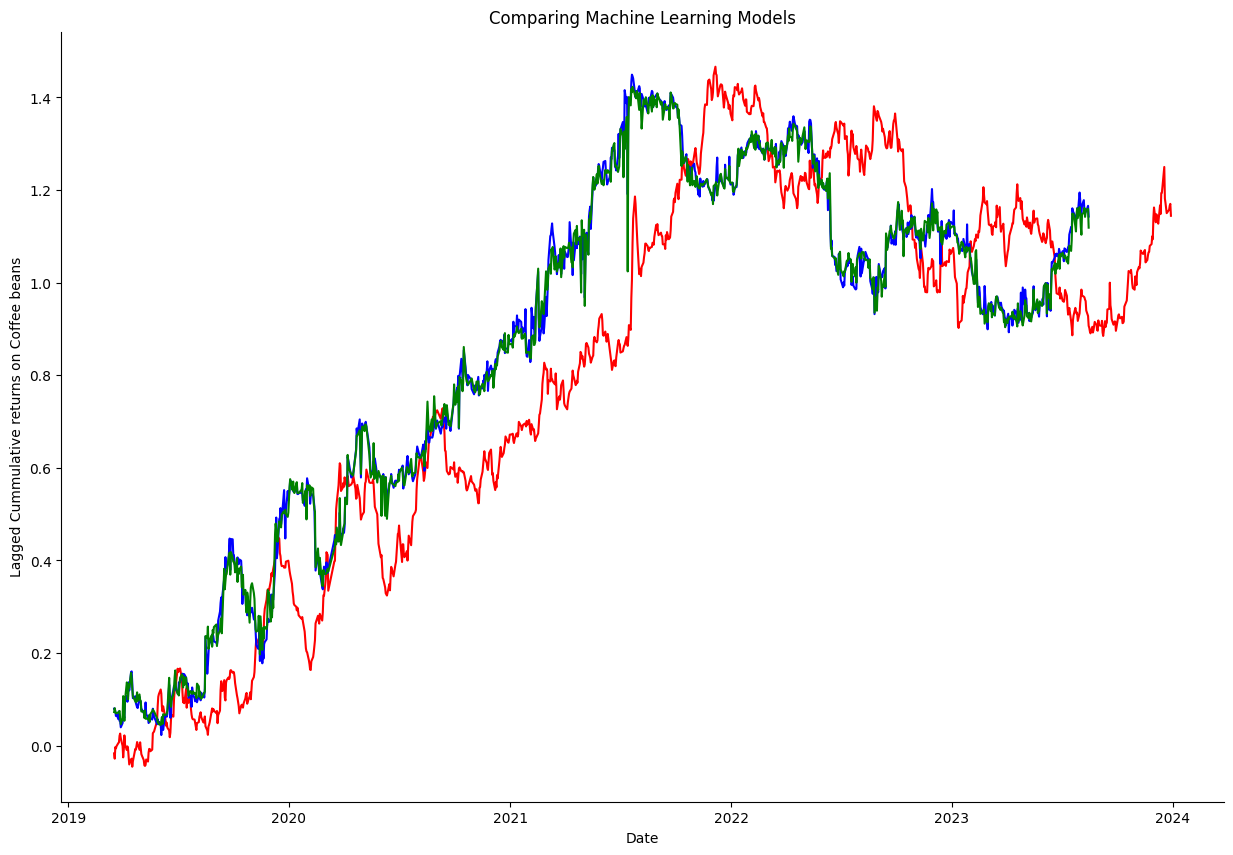

In [355]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(data=main, x='Date', y='cum_lag_return', ax=ax,color='red')
sns.lineplot(data=main, x='Date', y='GradientBoosting_Predicted', ax=ax, color='blue')
sns.lineplot(data=main, x='Date', y='RandomForest_Predicted', ax=ax, color='green')


ax.set_title('Comparing Machine Learning Models')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Lagged Cummulative returns on Coffee beans")


plt.show()


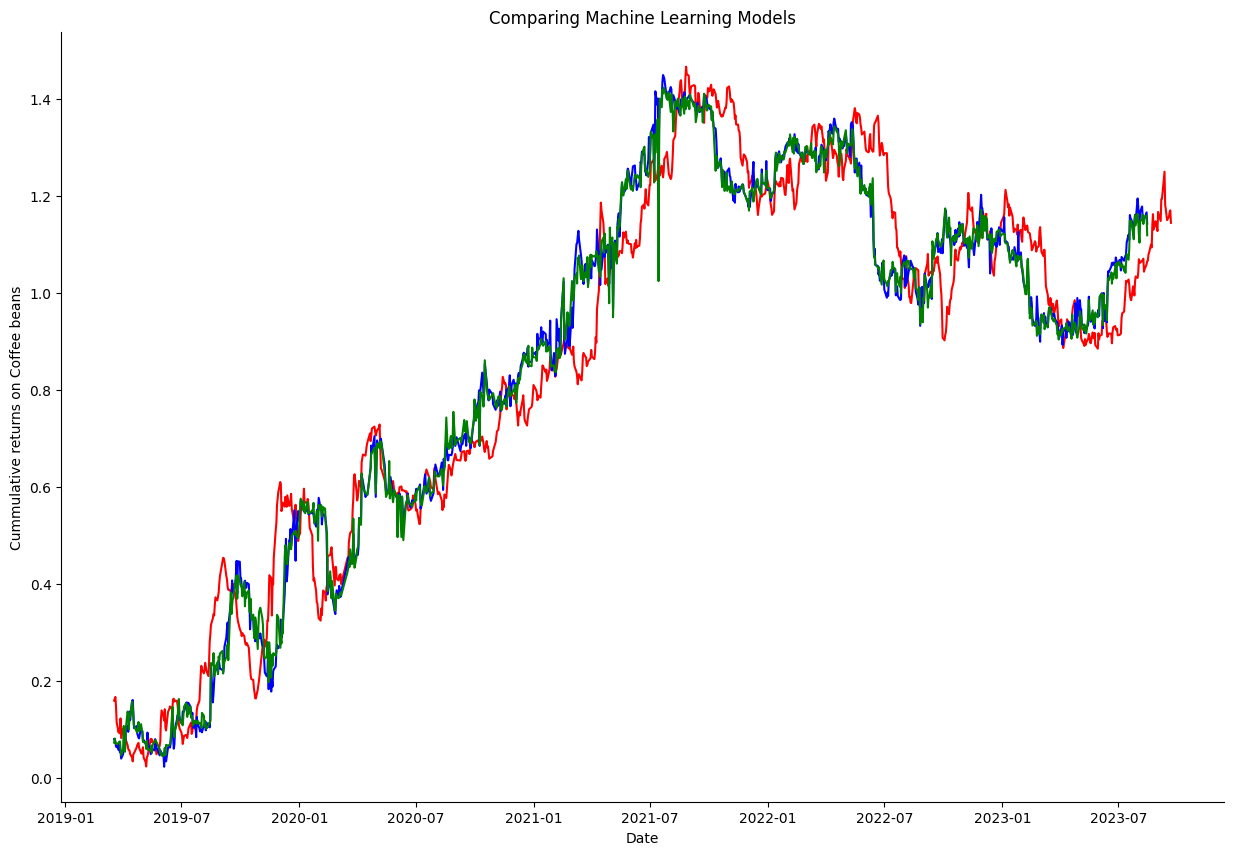

In [358]:
fig, ax = plt.subplots(figsize=(15,10))

main['cum_lag_return_1'] = main['cum_lag_return'].shift(-70)
sns.lineplot(data=main, x='Date', y='cum_lag_return_1', ax=ax,color='red')
sns.lineplot(data=main, x='Date', y='GradientBoosting_Predicted', ax=ax, color='blue')
sns.lineplot(data=main, x='Date', y='RandomForest_Predicted', ax=ax, color='green')


ax.set_title('Comparing Machine Learning Models')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Cummulative returns on Coffee beans")

plt.show()

#### Now let's consider minimising the [MSE] of Random Forest Regressor and Gradiant Boosted Regressor

In [346]:

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=4,
        min_samples_leaf=2,
        min_samples_split=2,
        n_estimators=50,
    ))
])
pipe =pipeline.fit(X_train, y_train)

Y_grb = pd.Series(pipe.predict(X))
main['GradientBoosting_Predicted'] = Y_grb

In [347]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        max_depth=1,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=150,
    ))
])
pipe = pipeline.fit(X_train, y_train)
Y_rfr = pd.Series(pipe.predict(X))
main['RandomForest_Predicted'] = Y_rfr

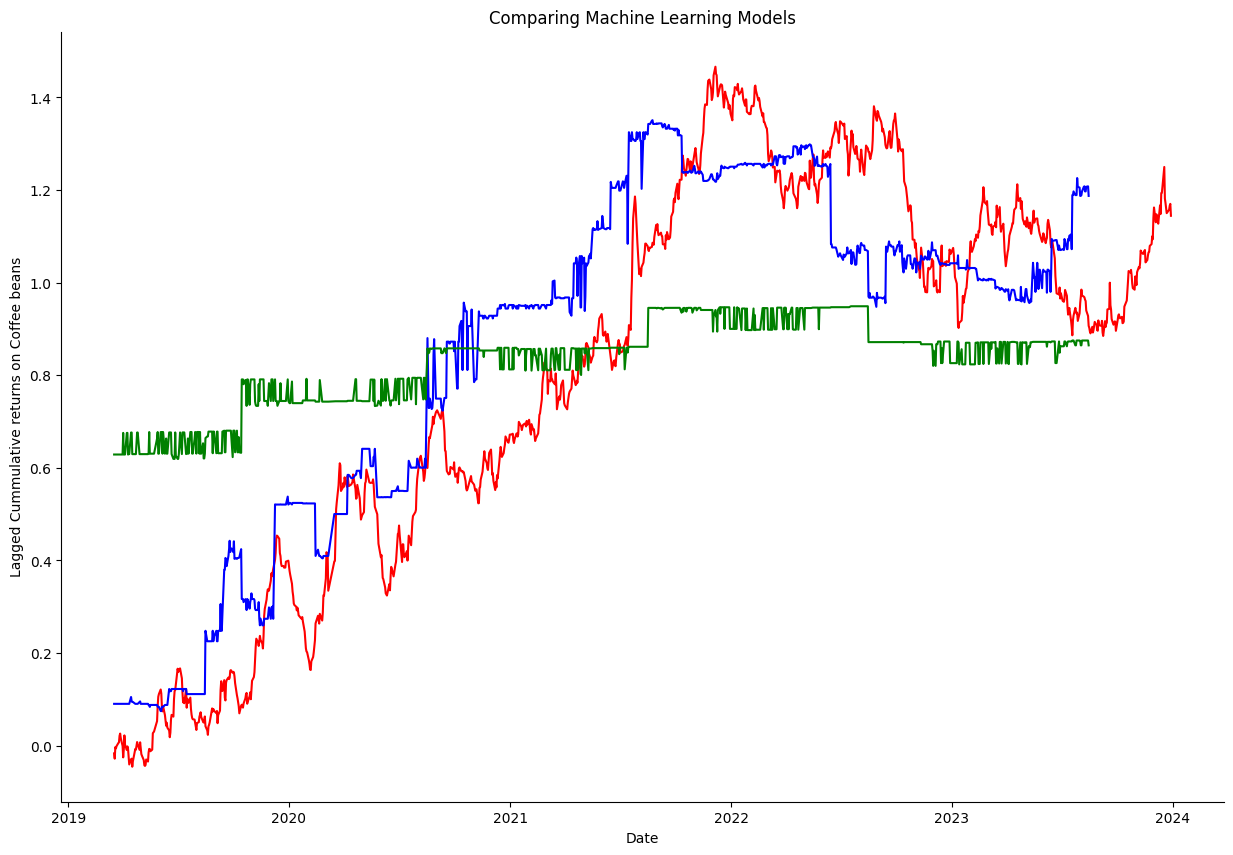

In [348]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(data=main, x='Date', y='cum_lag_return', ax=ax,color='red')
sns.lineplot(data=main, x='Date', y='GradientBoosting_Predicted', ax=ax, color='blue')
sns.lineplot(data=main, x='Date', y='RandomForest_Predicted', ax=ax, color='green')


ax.set_title('Comparing Machine Learning Models')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Lagged Cummulative returns on Coffee beans")

plt.show()


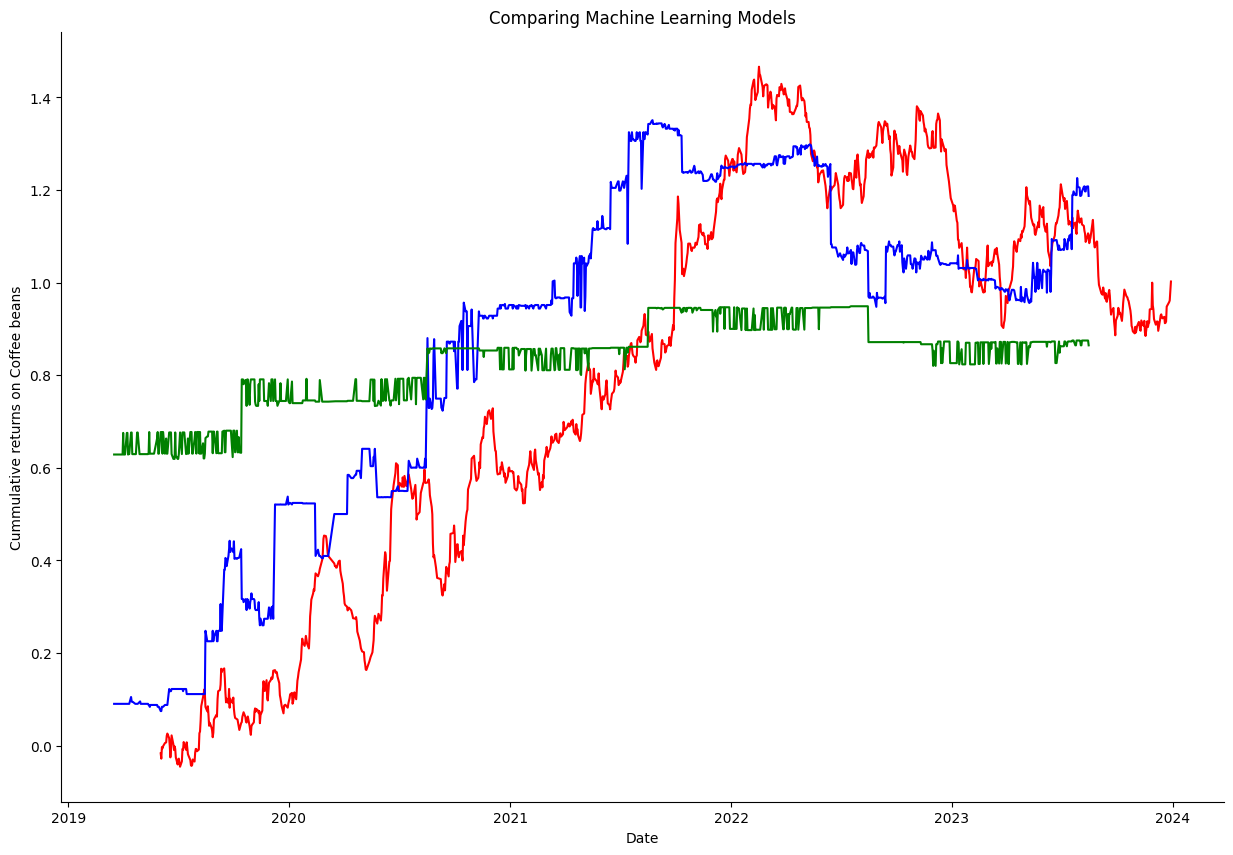

In [349]:
fig, ax = plt.subplots(figsize=(15,10))

main['cum_lag_return_1'] = main['cum_lag_return'].shift(50)
sns.lineplot(data=main, x='Date', y='cum_lag_return_1', ax=ax,color='red')
sns.lineplot(data=main, x='Date', y='GradientBoosting_Predicted', ax=ax, color='blue')
sns.lineplot(data=main, x='Date', y='RandomForest_Predicted', ax=ax, color='green')


ax.set_title('Comparing Machine Learning Models')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Cummulative returns on Coffee beans")

plt.show()